In [1]:
%load_ext cython
import pyrost as rst
# import speckle_tracking as st
from pyrost.bin import *
from pyrost import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
from multiprocessing import cpu_count
from importlib import reload
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb, siunitx}'
plt.rcParams['text.usetex'] = 'True'


pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport.pyximport.PyxImporter at 0x7fac188f5a90>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'gf', 'ggm', 'make_mll_slice', 'np']


# Multislice

In [3]:
wl = st_sim.MLL.en_to_wl / 20e3
params = st_sim.MSParams.import_default(x_step=5e-5, z_step=5e-3, n_min=100, n_max=5000,
                                        focus=1.5e3, mll_sigma=5e-5, mll_wl=wl, wl=wl, x_max=30,
                                        mll_depth=5.)
mll = st_sim.MLL.import_params(params)
print(mll.layers.shape)

(999, 4900)


In [4]:
ms_prgt = st_sim.MSPropagator(params, mll)
ms_prgt.beam_propagate()

   0%            Slice 0 / 999 [00:00<?, ?it/s]

In [5]:
det_dist = 2e5
M = det_dist / params.focus * 1.5
wft = ms_prgt.beam_profile[-1]
wft_focus = rsc_wp(wft, params.x_step, 4 * params.x_step, params.focus, params.wl)
wft_far = fraunhofer_wp(wft, params.x_step, M * params.x_step, det_dist, params.wl)

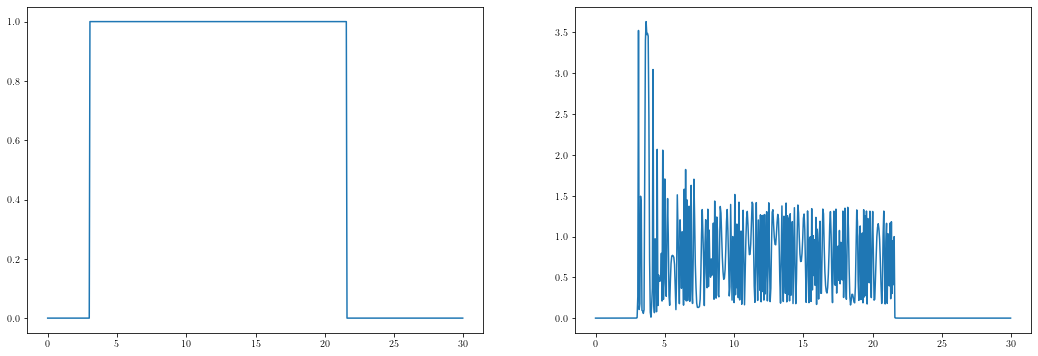

In [6]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(ms_prgt.x_arr[::1000], np.abs(ms_prgt.beam_profile[0, ::1000])**2)
axes[1].plot(ms_prgt.x_arr[::1000], np.abs(ms_prgt.beam_profile[-1, ::1000])**2)
plt.show()

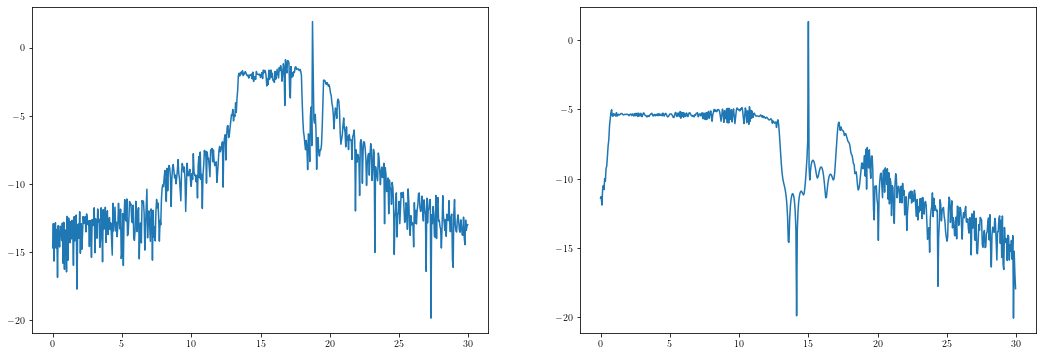

In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(ms_prgt.x_arr[::1000], np.log(np.abs(wft_focus[::1000])**2))
axes[1].plot(ms_prgt.x_arr[::1000], np.log(np.abs(wft_far[::1000])**2))
plt.show()

In [5]:
z_arr = np.linspace(0.2 * params.focus, 2. * params.focus)
ds_beam, x_arr = ms_prgt.beam_downstream(z_arr, 4 * params.x_step)

  0%|          | 0/50 [00:00<?, ?it/s]

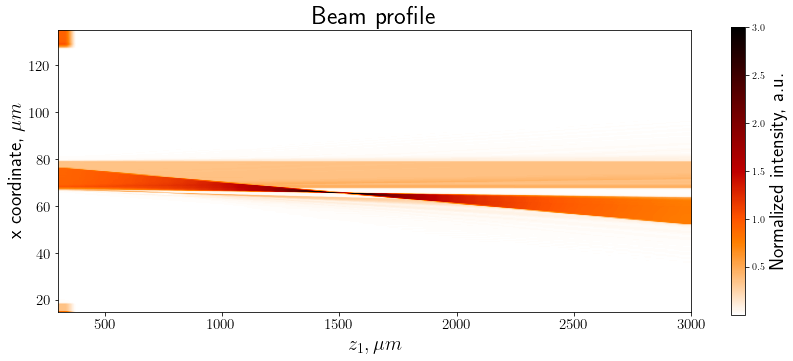

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
im1 = ax.imshow(np.abs(ds_beam.T[::10]), vmax=3., cmap='gist_heat_r',
                extent=[z_arr.min(), z_arr.max(), x_arr.min(), x_arr.max()])
cbar = fig.colorbar(im1, ax=ax, shrink=0.7)
cbar.ax.set_ylabel('Normalized intensity, a.u.', fontsize=20)
ax.set_title('Beam profile', fontsize=25)
ax.set_ylabel(r'x coordinate, $\mu m$', fontsize=20)
ax.set_aspect(10)
ax.tick_params(labelsize=15)
ax.set_xlabel(r'$z_1, \mu m$', fontsize=20)
plt.tight_layout()
# plt.savefig('figures/mll_beam.png', dpi=300)
plt.show()

# Beamtime preparation

In [3]:
import re

cxi_prt = rst.cxi_protocol(default_paths={'data': 'entry/instrument/detector/data',
                                          'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
                                          'y_pixel_size': 'entry/instrument/detector/y_pixel_size'})
log_prt = rst.log_protocol()
cxi_loader = rst.cxi_loader(cxi_prt)
scan_name = 2934
log_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-logs/Scan_{scan_name:d}.log'
dir_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/scan-frames/Scan_{scan_name:d}'
paths = [os.path.join(dir_path, path) for path in os.listdir(dir_path)
         if path.endswith('Lambda.nxs')]
paths = sorted(paths, key=lambda path: int(re.search('\d*(?=_Lambda)', path)[0]))
data = cxi_loader.load_data(paths)
attrs = cxi_loader.load_attributes(paths[0])
log_attrs = log_prt.load_attributes(log_path)

In [4]:
translations = np.tile([[log_attrs['x_sample'], log_attrs['y_sample'], log_attrs['z_sample']]],
                       (log_attrs['n_steps'], 1)) * 1e-9
if log_attrs['scan_type'] == 'X-SAM':
    translations[:, 0] = log_prt.load_data(log_path) * 1e-9
elif log_attrs['scan_type'] == 'Y-SAM':
    translations[:, 1] = log_prt.load_data(log_path) * 1e-9

In [8]:
fs_vec = np.array([0, -1, 0], dtype=cxi_prt.get_dtype('basis_vectors'))
ss_vec = np.array([1, 0, 0], dtype=cxi_prt.get_dtype('basis_vectors'))
pix_vec = np.array([attrs['x_pixel_size'], attrs['y_pixel_size'], 0])
pix_vec

array([55., 55.,  0.])

In [ ]:
cxi_prt = rst.cxi_protocol(default_paths={'data': 'entry/data',
                                          'distance': 'entry/instrument/detector/detector_distance',
                                          'wavelength': 'entry/instrument/beam/incident_wavelength',
                                          'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
                                          'y_pixel_size': 'entry/instrument/detector/y_pixel_size'})
cxi_loader = rst.cxi_loader(cxi_prt)
cxi_loader.load('/gpfs/cfel/cxi/scratch/user/jdressel/0001626_master.h5')

In [250]:
with h5py.File('/gpfs/cfel/cxi/scratch/user/jdressel/0001626_master.h5', 'r') as cxi_file:
    print(cxi_file['entry/instrument/detector/geometry/orientation'].keys())

<KeysViewHDF5 []>


# ST Simulation

In [56]:
params = st_sim.STParams.import_default(bar_size=0.7, bar_sigma=0.18, bar_atn=0.2,
                                        bulk_atn=0.1, p0 = 5e4, th_s=8e-5, n_frames=200,
                                        offset=2.0, step_size=0.1, focus=1500, defocus=500,
                                        alpha=0.05, ab_cnt=0.7, bar_rnd=0.7, ap_x=80, ap_y=10, det_dist=1.5e6,
                                        fs_size=2000, ss_size=2000)

globals().update(**params.export_dict())
print(params)

{'exp_geom': {'defocus': 500.0, 'det_dist': 1500000.0, 'n_frames': 200, 'step_size': 0.1, 'step_rnd': 0.2}, 'detector': {'fs_size': 2000, 'pix_size': 55.0, 'ss_size': 2000}, 'source': {'p0': 50000.0, 'th_s': 8e-05, 'wl': 7.29e-05}, 'lens': {'alpha': 0.05, 'ap_x': 80.0, 'ap_y': 10.0, 'focus': 1500.0, 'ab_cnt': 0.7}, 'barcode': {'bar_atn': 0.2, 'bar_rnd': 0.7, 'bar_sigma': 0.18, 'bar_size': 0.7, 'bulk_atn': 0.1, 'offset': 2.0}, 'system': {'seed': 1327236465000179537}}


In [57]:
n_x = params.x_wavefront_size()
n_y = params.y_wavefront_size()
nx_arr = np.arange(-n_x // 2, n_x // 2)
ny_arr = np.arange(-n_y // 2, n_y // 2)
lens_wfx, lens_wfy, dx0, dy0 = params.lens_wavefronts(return_dxdy=True)
print(n_x, n_y)

234110 20118


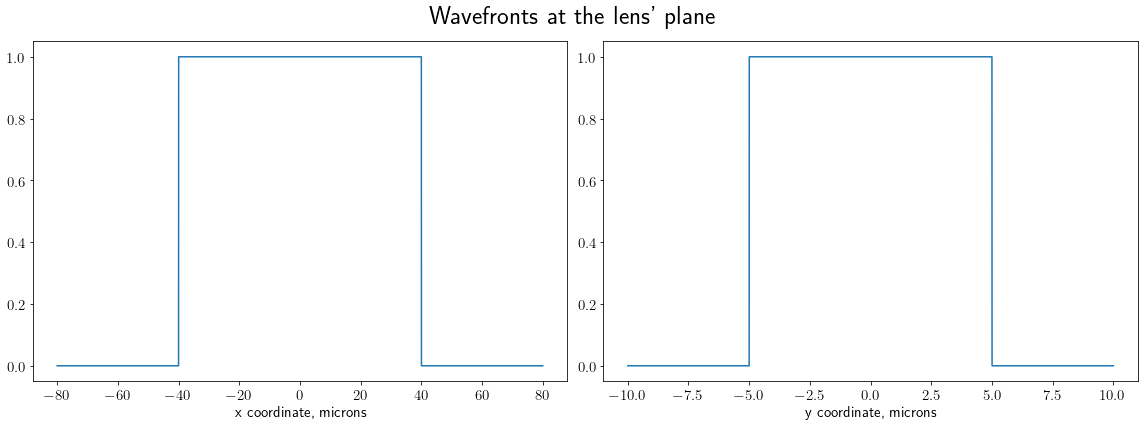

In [58]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx0 * nx_arr, np.abs(lens_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy0 * ny_arr, np.abs(lens_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the lens' plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/lens_wf.pdf')

In [59]:
dx1, dy1 = dx0 * params.defocus / params.focus, dy0
z01 = params.focus + params.defocus
%time defoc_wfx = rsc_wp(lens_wfx, dx0, dx1, z01, params.wl, num_threads=1)
%time defoc_wfy = rsc_wp(lens_wfy, dy0, dy1, z01, params.wl, num_threads=12)

CPU times: user 144 ms, sys: 8.87 ms, total: 153 ms
Wall time: 152 ms
CPU times: user 17 ms, sys: 5 µs, total: 17 ms
Wall time: 16.8 ms


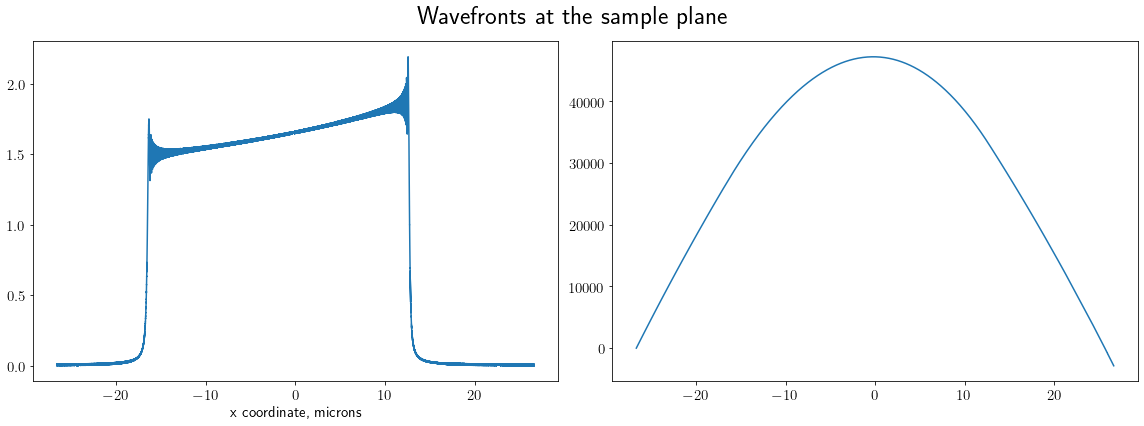

In [60]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx1 * nx_arr, np.abs(defoc_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dx1 * nx_arr, np.unwrap(np.angle(defoc_wfx)))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the sample plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/sample_wf.pdf')

In [61]:
x0, x1 = params.beam_span(params.defocus)
x1 += params.step_size * params.n_frames
bar_pos = bar_positions(x0 + params.offset, x1 - params.offset, params.bar_size, params.bar_rnd, 0)

In [63]:
smp_pos = params.sample_positions()
x_arr = dx1 * nx_arr + smp_pos[:, None]
%time b_tr = barcode_profile(x_arr=x_arr, bars=bar_pos, bulk_atn=params.bulk_atn, \
                             bar_atn=params.bar_atn, bar_sigma=params.bar_sigma, \
                             num_threads=32)
smp_wfx = defoc_wfx * b_tr

CPU times: user 13.2 s, sys: 272 ms, total: 13.4 s
Wall time: 648 ms


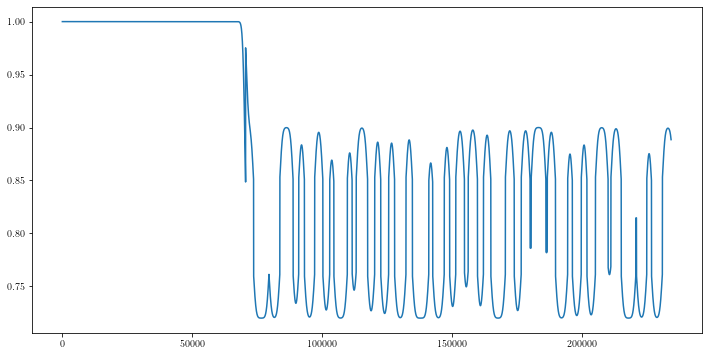

In [66]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.abs(b_tr[10]))
plt.show()

In [67]:
dx2, dy2 = params.fs_size * params.pix_size / n_x, params.ss_size * params.pix_size / n_y
%time det_wfx = fraunhofer_wp(smp_wfx, dx1, dx2, params.det_dist, params.wl, num_threads=64)
%time det_wfy = fraunhofer_wp(defoc_wfy, dy1, dy2, params.det_dist, params.wl, num_threads=64)
print(smp_wfx.shape, det_wfx.shape)

CPU times: user 45.9 s, sys: 890 ms, total: 46.8 s
Wall time: 2.08 s
CPU times: user 12.2 ms, sys: 1.02 ms, total: 13.2 ms
Wall time: 13 ms
(200, 234110) (200, 234110)


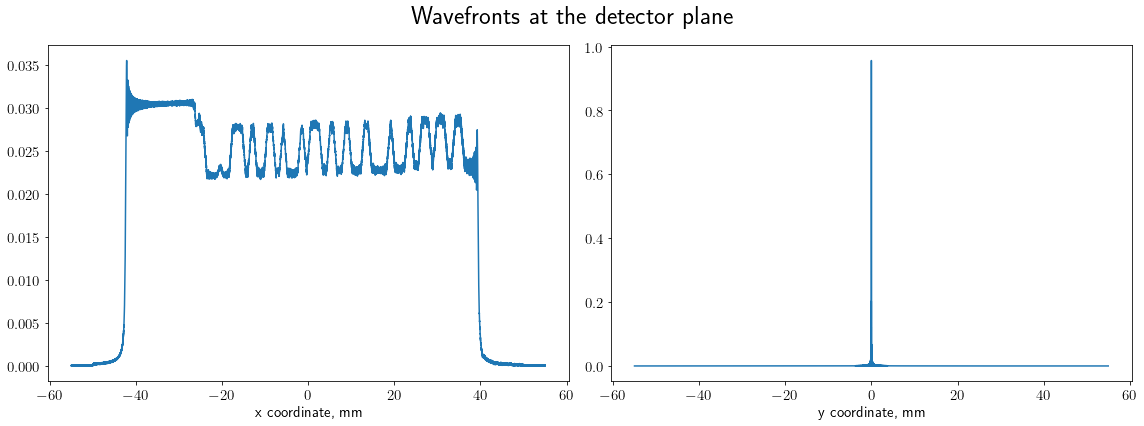

In [68]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.abs(det_wfx[2]))
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.abs(det_wfy))
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_wf.pdf')

In [69]:
sc_x = params.source_curve(params.defocus + params.det_dist, dx2)
sc_y = params.source_curve(params.defocus + params.det_dist, dy2)
pfx = np.sqrt(params.p0) / params.ap_x * np.abs(det_wfx)**2
pfy = np.sqrt(params.p0) / params.ap_y * np.abs(det_wfy)**2
print(pfx.shape, sc_x.shape)
%time det_ix = fft_convolve(pfx, sc_x, num_threads=32)
%time det_iy = fft_convolve(pfy, sc_y, num_threads=32)
# print(det_ix.shape, det_iy.shape)

(200, 234110) (2043,)
CPU times: user 13.1 s, sys: 302 ms, total: 13.4 s
Wall time: 665 ms
CPU times: user 1.75 ms, sys: 72 µs, total: 1.83 ms
Wall time: 1.76 ms


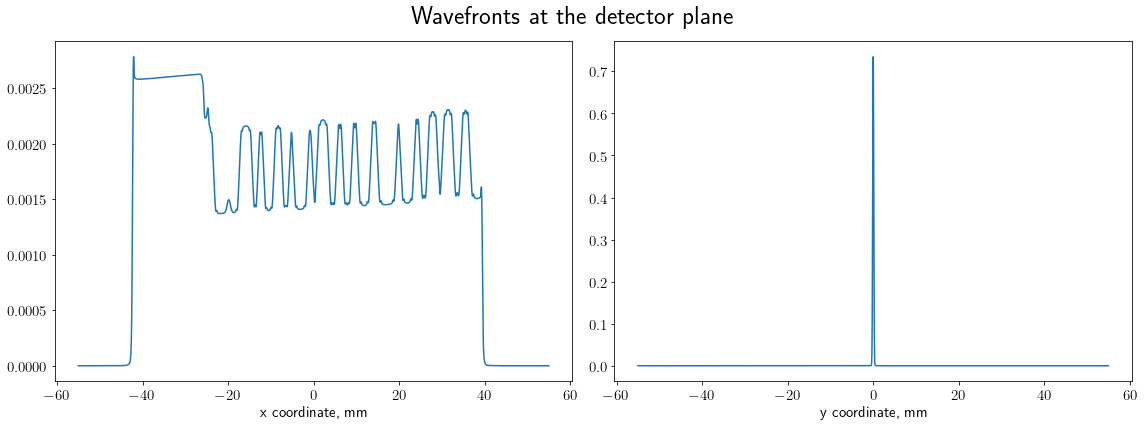

In [70]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, det_ix[0])
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, det_iy)
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_int.pdf')

In [106]:
wfx = np.ones(params.fs_size)
wfy = np.ones(params.ss_size)
%time frames = make_frames(pfx=det_ix, pfy=det_iy, dx=dx2, dy=dy2, \
                           shape=(params.ss_size, params.fs_size), \
                           seed=-1, num_threads=16)
%time wfield = make_whitefield(frames, np.ones(frames.shape, dtype=bool), 0, 16)
frames.shape, wfield.shape

CPU times: user 9.43 s, sys: 1.76 s, total: 11.2 s
Wall time: 845 ms
CPU times: user 25.1 s, sys: 181 ms, total: 25.3 s
Wall time: 1.95 s


((200, 2000, 2000), (2000, 2000))

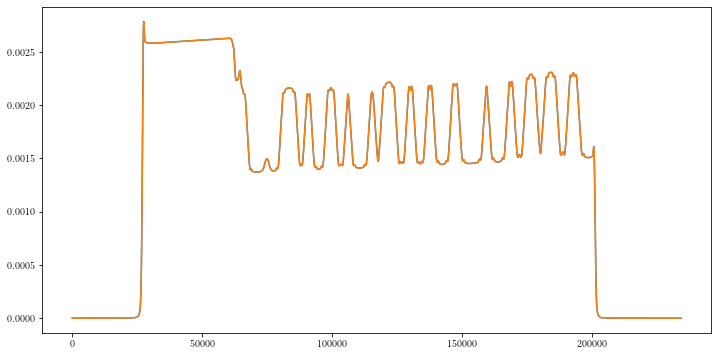

In [111]:
from scipy.interpolate import interp1d

x = np.arange(pfx.shape[1])
x_new = np.linspace(0, pfx.shape[1] - 1, params.fs_size)


%matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.plot(x, det_ix[0])
axes.plot(x_new, interp1d(x, det_ix[0])(x_new))
plt.show()

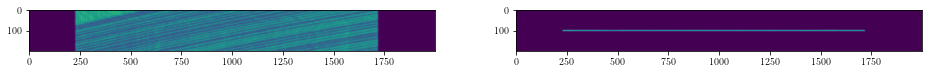

In [78]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(frames.sum(axis=1))
axes[1].imshow(wfield[(params.ss_size // 2 - 100):(params.ss_size // 2 + 100), :])
plt.show()

In [19]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [20]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [112]:
params = st_sim.STParams.import_default(bar_size=0.7, bar_sigma=0.18, bar_atn=0.18,
                                        bulk_atn=0.15, rnd_dev=0.7, p0=5e4, th_s=1.5e-4,
                                        n_frames=200, defocus=40, alpha=0.04, ab_cnt=0.7,
                                        step_size=0.15, step_rnd=0.8, seed=8457259)
st_conv = st_sim.STConverter()
sim_obj = st_sim.STSim(params, backend='numpy')
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

In [113]:
grad, sweep = data.defocus_sweep(np.linspace(20e-6, 100e-6, 20))

Generating defocus sweep:   0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
st_obj = data.get_st()

st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=8., ls_pm=2.5, blur=6, verbose=True, n_iter=30)

   0%            Iteration 0 / 30 [00:00<?, ?it/s]

Initial MSE = 0.218514, Initial ls_ri = 8.00


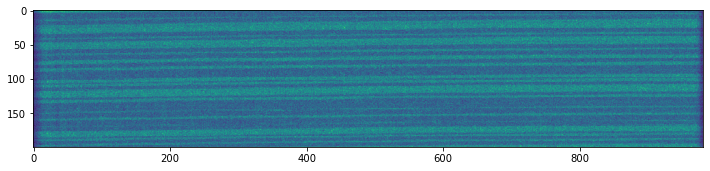

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

In [3]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'gf', 'ggm', 'np']


In [7]:
params = st_sim.STParams.import_default(bar_size=0.25, bar_sigma=0.18, bar_atn=0.22,
                                        bulk_atn=0.15, bar_rnd=0.7, p0 = 5e4, th_s=8e-5,
                                        n_frames=200, defocus=30, alpha=0.03,
                                        ab_cnt=0.7)

st_conv = st_sim.STConverter()

In [43]:
sim_obj = st_sim.STSim(params=params, backend='numpy')
data = st_conv.export_data(sim_obj.ptychograph(), sim_obj)

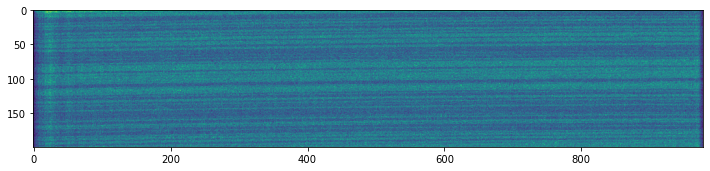

In [44]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(data.get('data')[:, 0])
plt.show()

In [45]:
sw_fs=10
sw_ss=0
ls_ri=8.
ls_pm=2.5
blur=6
n_iter=10
f_tol=1e-6
momentum=0.
learning_rate=1e1
gstep=.1

st_obj = data.get_st(num_threads=32)

velocity = 0.0
obj = st_obj.update_reference(ls_ri=ls_ri)
obj.update_errors.inplace_update()
extra = {'errors': [obj.error_frame.mean()],
         'lss_ri': [ls_ri]}
print('Initial MSE = {:.6f}, Initial ls_ri = {:.2f}'.format(extra['errors'][-1],
                                                            extra['lss_ri'][-1]))
for it in range(1, n_iter + 1):
    # Update pixel_map
    new_obj = obj.update_pixel_map(ls_pm=ls_pm, sw_fs=sw_fs, sw_ss=sw_ss)
    obj.pixel_map += gaussian_filter(new_obj.pixel_map - obj.pixel_map,
                                     (0, blur, blur), mode='nearest',
                                     num_threads=st_obj.num_threads)

    # Update ls_ri
    grad = (obj.mse_total(ls_ri + gstep) - extra['errors'][-1]) / gstep
    velocity = np.clip(momentum * velocity - learning_rate * grad,
                       -0.75 * ls_ri, 0.75 * ls_ri)
    ls_ri += velocity
    extra['lss_ri'].append(ls_ri)

    # Update reference_image
    obj.update_reference.inplace_update(ls_ri=ls_ri)
    obj.update_errors.inplace_update()
    extra['errors'].append(obj.error_frame.mean())
    print('Iteration No. {:d}: Total MSE = {:.6f}, ls_ri = {:.2f}'.format(it, extra['errors'][-1],
                                                                          extra['lss_ri'][-1]))

Initial MSE = 0.349431, Initial ls_ri = 8.00
Iteration No. 1: Total MSE = 0.316340, ls_ri = 10.46
Iteration No. 2: Total MSE = 0.281058, ls_ri = 13.35
Iteration No. 3: Total MSE = 0.246875, ls_ri = 16.38
Iteration No. 4: Total MSE = 0.219866, ls_ri = 18.99
Iteration No. 5: Total MSE = 0.199460, ls_ri = 21.06
Iteration No. 6: Total MSE = 0.187906, ls_ri = 22.29
Iteration No. 7: Total MSE = 0.182527, ls_ri = 22.84
Iteration No. 8: Total MSE = 0.179597, ls_ri = 23.08
Iteration No. 9: Total MSE = 0.178431, ls_ri = 23.20
Iteration No. 10: Total MSE = 0.177583, ls_ri = 23.28


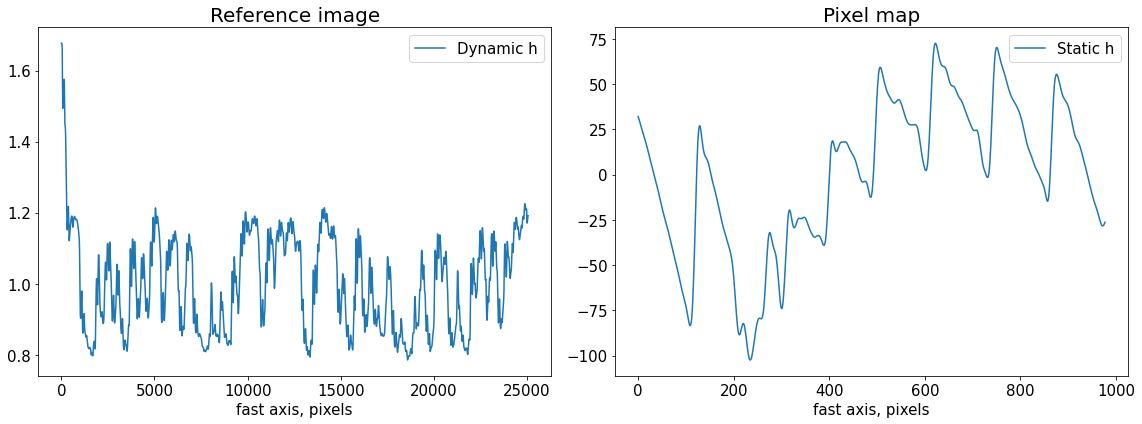

In [46]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(obj.reference_image[0], label='Dynamic h')
axes[1].plot((obj.pixel_map - st_obj.pixel_map)[1, 0] - 
             (obj.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()

In [41]:
st_obj = data.get_st(num_threads=16)
st_res = st_obj.iter_update_gd(sw_fs=10, sw_ss=0, ls_ri=8., ls_pm=2.5, blur=6, verbose=True, n_iter=30)

Initial MSE = 0.440567, Initial ls_ri = 8.00
Iteration No. 1: Total MSE = 0.400667, ls_ri = 10.88
Iteration No. 2: Total MSE = 0.351141, ls_ri = 14.91
Iteration No. 3: Total MSE = 0.309532, ls_ri = 18.93
Iteration No. 4: Total MSE = 0.283405, ls_ri = 21.69
Iteration No. 5: Total MSE = 0.269093, ls_ri = 23.24
Iteration No. 6: Total MSE = 0.260826, ls_ri = 24.06
Iteration No. 7: Total MSE = 0.256253, ls_ri = 24.50
Iteration No. 8: Total MSE = 0.253984, ls_ri = 24.78
Iteration No. 9: Total MSE = 0.250753, ls_ri = 25.04
Iteration No. 10: Total MSE = 0.248626, ls_ri = 25.29
Iteration No. 11: Total MSE = 0.245684, ls_ri = 25.53
Iteration No. 12: Total MSE = 0.243465, ls_ri = 25.80
Iteration No. 13: Total MSE = 0.242260, ls_ri = 25.93
Iteration No. 14: Total MSE = 0.240375, ls_ri = 26.16
Iteration No. 15: Total MSE = 0.239756, ls_ri = 26.21
Iteration No. 16: Total MSE = 0.239550, ls_ri = 26.19
Iteration No. 17: Total MSE = 0.239581, ls_ri = 26.14


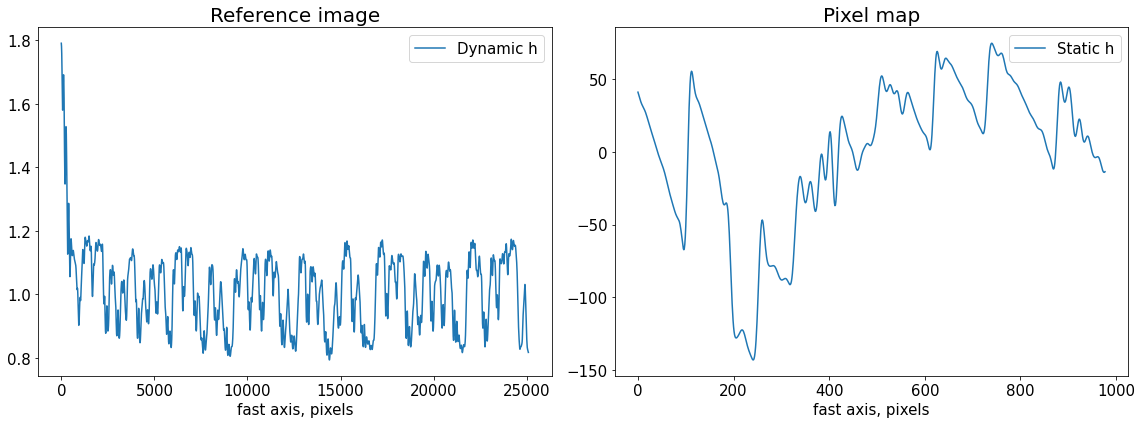

In [42]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], label='Dynamic h')
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0] - 
             (st_res.pixel_map - st_obj.pixel_map)[1, 0].mean(), label='Static h')
axes[0].set_title('Reference image', fontsize=20)
axes[1].set_title('Pixel map', fontsize=20)
for ax in axes:
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlabel('fast axis, pixels', fontsize=15)
plt.tight_layout()
plt.show()

In [27]:
data = data.update_phase(st_res)
fit_obj = data.get_fit()
fit_obj.defocus = np.abs(fit_obj.defocus)
fit = fit_obj.fit()
ph_fit = fit_obj.fit_phase()

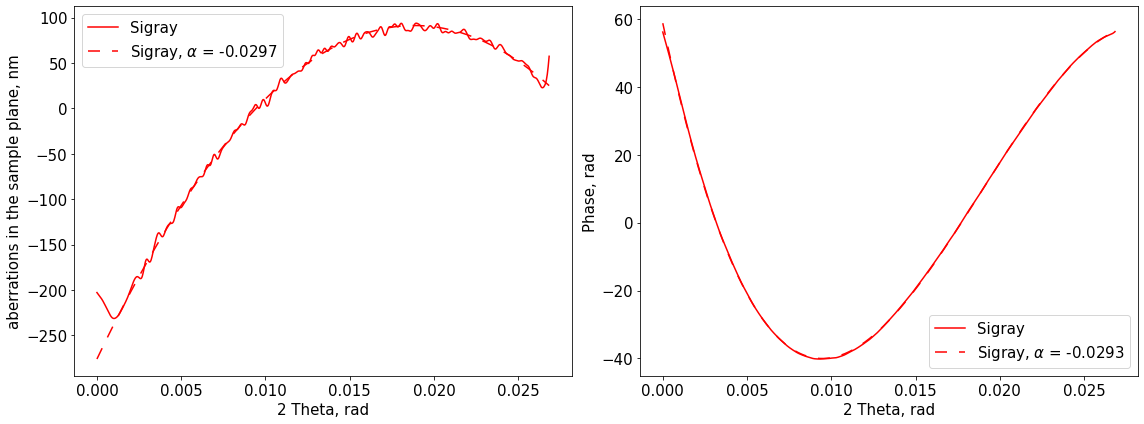

In [28]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.pixel_aberrations * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label='Sigray', c='r')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.model(fit['fit']) * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[0].set_ylabel('aberrations in the sample plane, nm', fontsize=15)
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.phase, label='Sigray', c='r')
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap, fit_obj.model(ph_fit['ph_fit']), 
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(ph_fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[1].set_ylabel('Phase, rad', fontsize=15)
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [10]:
loader = rst.loader()
data = loader.load('results/exp/diatom.cxi', roi=(70, 420, 50, 455), good_frames=np.arange(1, 121))
data = data.update_mask(method='perc-bad', pmin=0.05, pmax=99.998)

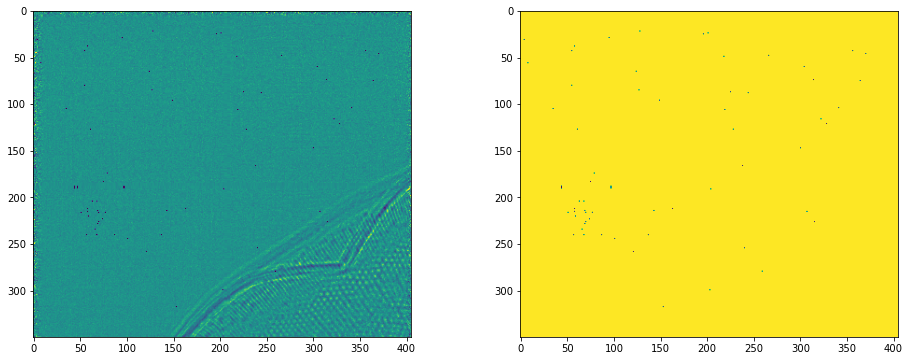

In [11]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(np.where(data.get('mask')[0],
                        data.get('data')[0] / data.get('whitefield'),
                        0), vmin=0.5, vmax=1.5)
axes[1].imshow(data.get('mask')[0], vmin=0, vmax=1)
plt.show()

In [12]:
st_obj = data.get_st()
st_obj = st_obj.update_reference(ls_ri=1.1, sw_ss=0, sw_fs=0)

In [14]:
st_obj = data.get_st()
st_rgd = st_obj.iter_update_gd(ls_ri=1.1, ls_pm=1.5, sw_fs=2, sw_ss=2, n_iter=4,
                               verbose=True, learning_rate=0.1)

Initial MSE = 0.874955, Initial ls_ri = 1.10
Iteration No. 1: Total MSE = 0.662130, ls_ri = 1.30
Iteration No. 2: Total MSE = 0.487592, ls_ri = 1.47
Iteration No. 3: Total MSE = 0.446233, ls_ri = 1.52
Iteration No. 4: Total MSE = 0.429475, ls_ri = 1.55


In [16]:
data.data.shape, data.mask.shape

((121, 516, 1556), (121, 516, 1556))

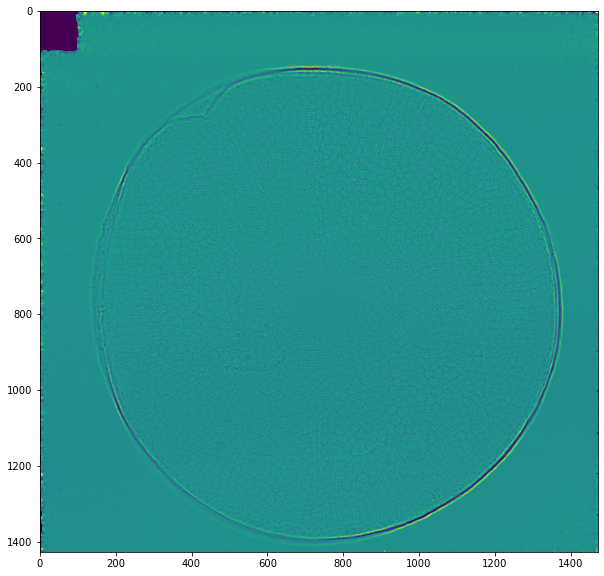

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(st_obj.reference_image, vmin=0.7, vmax=1.3)
ax.imshow(st_rgd.reference_image, vmin=0.7, vmax=1.3)
plt.show()

# Experimental results

In [296]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1100), 2165: (0, 1, 430, 1140),
            2188: (0, 1, 365, 1155), 2202: (0, 1, 275, 1100), 2274: (0, 1, 430, 1140), 2291: (0, 1, 430, 1140),
            2311: (0, 1, 440, 1220), 2312: (0, 1, 440, 1220), 2313: (0, 1, 430, 1220), 2557: (0, 1, 150, 1000),
            2797: (0, 1, 310, 1240), 2804: (0, 1, 180, 1220), 2894: (0, 1, 260, 1230), 2924: (0, 1, 250, 1200),
            2934: (0, 1, 320, 1240), 2936: (0, 1, 40, 1250), 2989: (0, 1, 160, 1240)}

scan_num = 2989
data_path = f'/gpfs/cfel/cxi/labs/MLL-Sigray/Processed/2021/Scan_{scan_num:d}/Scan_{scan_num:d}.cxi'
loader = rst.CXILoader()
data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num])
data = data.make_whitefield()
data = data.mirror_data(axis=1)

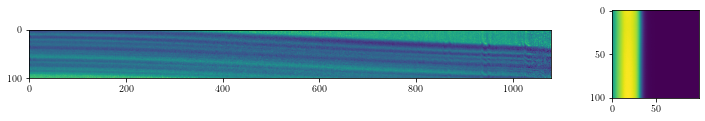

In [297]:
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 2, width_ratios=(6, 1))
ax0 = fig.add_subplot(gs[0])
ax0.imshow(data.get('data')[:, 0] / data.get('whitefield'), vmin=0.5, vmax=1.9)
ax1 = fig.add_subplot(gs[1])
ax1.imshow(data.data[:, 0, :100])
plt.show()

Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

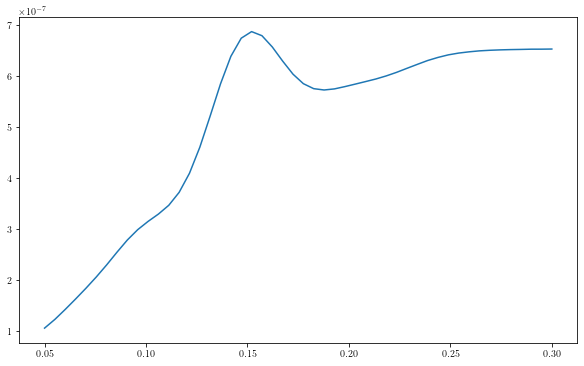

In [299]:
defoci = np.linspace(5e-5, 3e-4, 50)
ds_scan = data.defocus_sweep(defoci, ls_ri=30, return_sweep=False)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(defoci * 1e3, ds_scan)
plt.show()

In [300]:
data = data.update_defocus(defocus_fs=defoci[np.argmax(ds_scan)])

st_obj = data.get_st()

st_rgd = st_obj.iter_update_gd(ls_ri=4., ls_pm=3., blur=12., sw_fs=3, n_iter=150,
                               learning_rate=5e0, verbose=True)

   0%            Iteration 0 / 150 [00:00<?, ?it/s]

Initial MSE = 0.098999, Initial ls_ri = 4.00


In [301]:
data = data.update_phase(st_rgd)

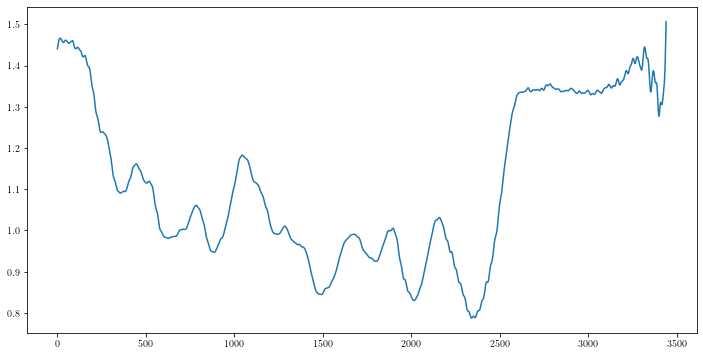

In [302]:
%matplotlib inline
fig, axes = plt.subplots(figsize=(12, 6))
axes.plot(st_rgd.reference_image[0])
plt.show()

In [305]:
center = 25
fit_rst = data.get_fit(center=center).remove_linear_term()
fit_rst = fit_rst.crop_data([10, fit_rst.pixels.size - 30])
fcf_rst = fit_rst.fit(max_order=3, loss='linear')

thetas, phase = np.loadtxt(f'results/phase_data_{scan_num:d}.txt',
                                   skiprows=1, delimiter=',')[::-1, [0, 2]].T
theta_ab = np.gradient(phase * fit_rst.wavelength / (2 * np.pi * fit_rst.pixel_size))
pixel_ab = theta_ab / fit_rst.pix_ap

fit_pxst = rst.AberrationsFit(defocus=data.defocus_fs, distance=data.distance,
                              pixels=thetas * data.distance / data.x_pixel_size,
                              pixel_aberrations=pixel_ab, pixel_size=data.x_pixel_size,
                              wavelength=data.wavelength).remove_linear_term()
fcf_pxst = fit_pxst.fit(max_order=3)

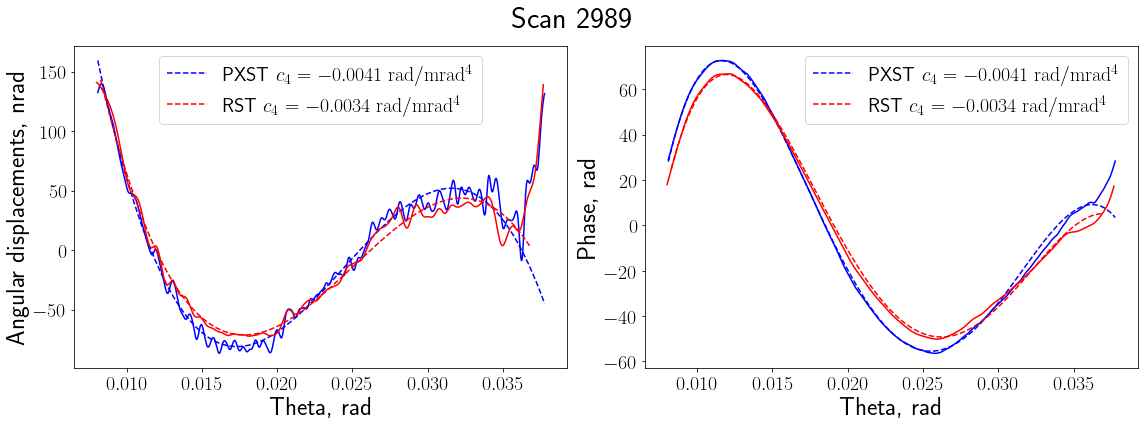

In [306]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Scan {scan_num:d}', fontsize=30)
axes[0].plot(fit_pxst.pixel_size / fit_pxst.distance * fit_pxst.pixels,
             fit_pxst.pixel_aberrations * fit_pxst.pix_ap * 1e9, 'b')
axes[0].plot(fit_pxst.pixel_size / fit_pxst.distance * fit_pxst.get('pixels'), 
             fit_pxst.model(fcf_pxst['fit']) * fit_pxst.pix_ap * 1e9, 'b--',
             label=fr"PXST $c_4 = {fcf_pxst['c_4']:.4f} \: \si{{\radian / \milli \radian^4}}$")
axes[0].plot(fit_rst.pixel_size / fit_rst.distance * fit_rst.pixels,
             fit_rst.pixel_aberrations * fit_rst.pix_ap * 1e9, 'r')
axes[0].plot(fit_rst.pixel_size / fit_rst.distance * fit_rst.get('pixels'),
             fit_rst.model(fcf_rst['fit']) * fit_rst.pix_ap * 1e9, 'r--',
             label=fr"RST $c_4 = {fcf_rst['c_4']:.4f} \: \si{{\radian / \milli \radian^4}}$")
axes[0].set_ylabel('Angular displacements, nrad', fontsize=25)

axes[1].plot(fit_pxst.pixel_size / fit_pxst.distance * fit_pxst.pixels,
             fit_pxst.phase, 'b')
axes[1].plot(fit_pxst.pixel_size / fit_pxst.distance * fit_pxst.get('pixels'),
             fit_pxst.model(fcf_pxst['ph_fit']), 'b--',
             label=fr"PXST $c_4={fcf_pxst['c_4']:.4f} \: \si{{\radian / \milli \radian^4}}$")
axes[1].plot(fit_rst.pixel_size / fit_rst.distance * fit_rst.pixels,
             fit_rst.phase, 'r')
axes[1].plot(fit_rst.pixel_size / fit_rst.distance * fit_rst.get('pixels'),
             fit_rst.model(fcf_rst['ph_fit']), 'r--',
             label=fr"RST $c_4={fcf_rst['c_4']:.4f} \: \si{{\radian / \milli \radian^4}}$")
axes[1].set_ylabel('Phase, rad', fontsize=25)
for ax in axes:
    ax.legend(fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlabel('Theta, rad', fontsize=25)
plt.tight_layout()
plt.show()

In [307]:
ph_to_rad = np.geomspace(1, (fit_rst.distance / fit_rst.pixel_size * 1e-3)**(fcf_rst['ph_fit'].size - 1),
                         fcf_rst['ph_fit'].size)[::-1]
rst_dict[scan_num] = ph_to_rad * fcf_rst['ph_fit']
pxst_dict[scan_num] = ph_to_rad * fcf_pxst['ph_fit']

In [308]:
fcf_rst['c_3'], fcf_rst['c_4'], rst_dict[scan_num]

(0.336062801703808,
 -0.003356517641575567,
 array([-3.35651764e-03,  3.36062802e-01, -1.15628414e+01,  1.55292866e+02,
        -6.43132350e+02]))

In [338]:
rst_dict = {key: value for key, value in sorted(rst_dict.items(), key=lambda item: item[0])}
pxst_dict = {key: value for key, value in sorted(pxst_dict.items(), key=lambda item: item[0])}
rst_dict

{2797: array([-3.19460331e-03,  2.56861185e-01, -7.09282448e+00,  7.80106277e+01,
        -2.85415768e+02]),
 2804: array([-3.05372754e-03,  2.45942873e-01, -6.39098395e+00,  5.87464968e+01,
        -1.40010681e+02]),
 2894: array([-5.87033091e-03,  3.80066429e-01, -6.65184400e+00,  1.38098833e+01,
         2.06691451e+02]),
 2936: array([-3.92192414e-03,  5.54847622e-01, -2.50795142e+01,  4.13037037e+02,
        -1.89601378e+03]),
 2989: array([-3.35651764e-03,  3.36062802e-01, -1.15628414e+01,  1.55292866e+02,
        -6.43132350e+02])}

In [340]:
# with open('results/rst_dict.d', 'wb') as file:
#     pickle.dump(rst_dict, file)
# with open('results/pxst_dict.d', 'wb') as file:
#     pickle.dump(pxst_dict, file)

In [358]:
c4_rst = np.stack(list(rst_dict.values()))[:, 0]
c4_pxst = np.stack(list(pxst_dict.values()))[:, 0]

np.sqrt((2 * (c4_rst - c4_pxst) / (c4_rst + c4_pxst))**2).mean()

0.11705294314024361

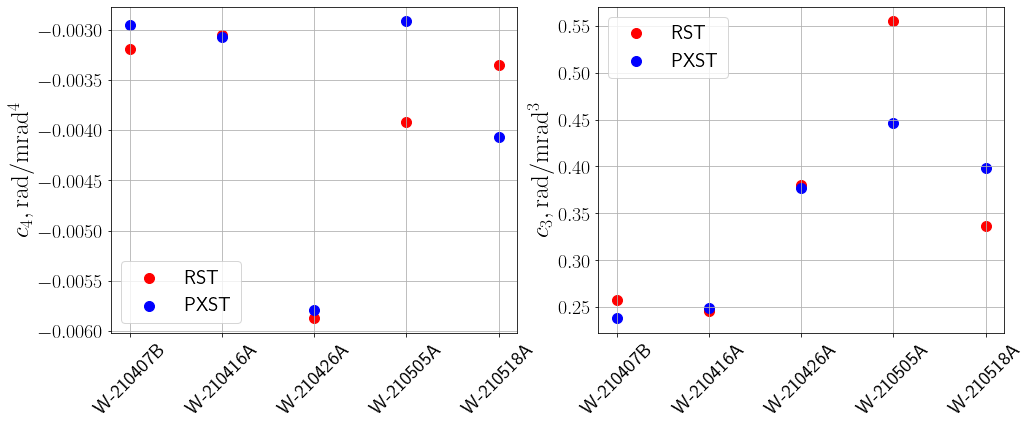

In [356]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].scatter(np.arange(len(rst_dict)), np.stack(list(rst_dict.values()))[:, 0], 100, 'r',
                label='RST')
axes[0].scatter(np.arange(len(pxst_dict)), np.stack(list(pxst_dict.values()))[:, 0], 100, 'b',
                label='PXST')
axes[0].set_ylabel(r'$c_4, \si{\radian / \milli \radian^4}$', fontsize=25)
axes[1].scatter(np.arange(len(rst_dict)), np.stack(list(rst_dict.values()))[:, 1], 100, 'r',
                label='RST')
axes[1].scatter(np.arange(len(pxst_dict)), np.stack(list(pxst_dict.values()))[:, 1], 100, 'b',
                label='PXST')
axes[1].set_ylabel(r'$c_3, \si{\radian / \milli \radian^3}$', fontsize=25)
for ax in axes:
    ax.set_xticks(np.arange(len(rst_dict)), minor=False)
    ax.set_xticklabels(['W-210407B', 'W-210416A', 'W-210426A', 'W-210505A', 'W-210518A'],
                       rotation=45, rotation_mode='default')
    ax.tick_params(labelsize=20)
    ax.legend(fontsize=20)
    ax.grid(True)
plt.show()

In [9]:
data_path = 'results/exp/scan_81763.cxi'
loader = rst.loader()
data_nsls = loader.load(data_path, roi=(0, 300, 200, 519))
data_nsls = data_nsls.update_mask(method='perc-bad', percentile=99.995)

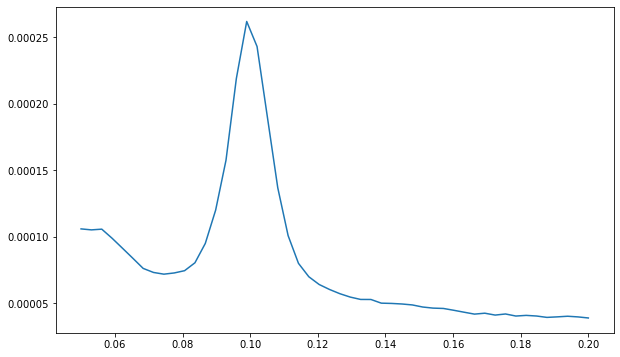

In [198]:
df_nsls = np.linspace(5e-5, 2e-4, 50)
dss_nsls = data_nsls.defocus_sweep(df_nsls, ls_ri=1.1, return_sweep=False)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(defoci * 1e3, ds_scan)
plt.show()

In [328]:
data.wavelength

array(7.09291753e-11)

In [295]:
data_nsls = data_nsls.update_defocus(defocus_fs=df_nsls[np.argmax(dss_nsls)])

st_obj_nsls = data_nsls.get_st()
st_obj_nsls = st_obj_nsls.update_reference(sw_ss=0, sw_fs=0, ls_ri=1.5)

st_rgd_nsls = st_obj_nsls.iter_update_gd(ls_ri=1.1, ls_pm=1.1, sw_fs=3, sw_ss=3, n_iter=20, verbose=True,
                                         learning_rate=0.1)

data_nsls = data_nsls.update_phase(st_rgd_nsls)

Initial MSE = 0.766755, Initial ls_ri = 1.10
Iteration No. 1: Total MSE = 0.553753, ls_ri = 1.30
Iteration No. 2: Total MSE = 0.445012, ls_ri = 1.41
Iteration No. 3: Total MSE = 0.389979, ls_ri = 1.49
Iteration No. 4: Total MSE = 0.433399, ls_ri = 1.47


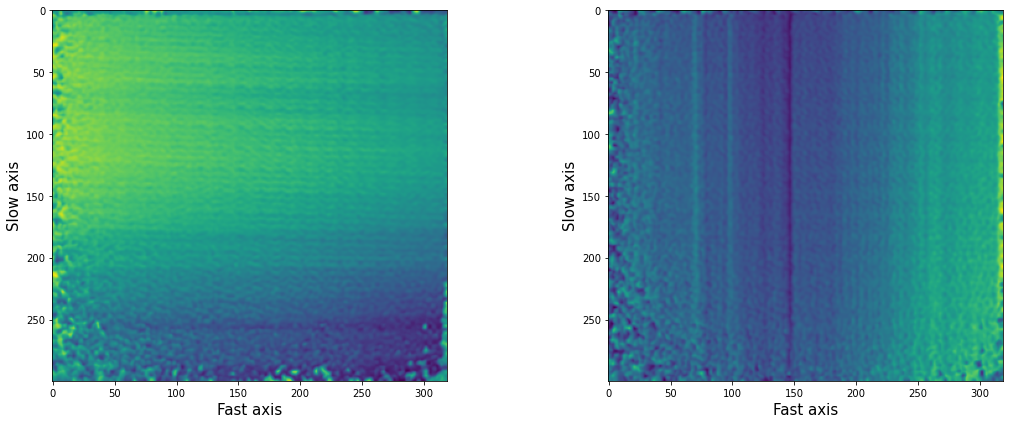

In [327]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0])
axes[1].imshow((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[1])
for ax in axes:
    ax.set_xlabel('Fast axis', fontsize=15)
    ax.set_ylabel('Slow axis', fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('nsls_pix_aberrations.pdf')

In [305]:
thetas = np.arange(10, 230) * data_nsls.y_pixel_size / data_nsls.distance
dev = np.interp(thetas, (fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
                   fit_obj.pixel_aberrations * data.defocus_fs * data.x_pixel_size / data.distance)

In [312]:
pix_shift = 5

# dev_ss = np.mean((st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0, :, 100:], axis=1, keepdims=True)
dev_ss = (st_rgd_nsls.pixel_map - data_nsls.get('pixel_map'))[0, :, [280]].T
dev_fs = np.zeros(dev_ss.shape, dtype=np.float64)
d_ab = (dev - dev_ss[10 + pix_shift:230 + pix_shift, 0] * \
        data_nsls.defocus_ss * data_nsls.y_pixel_size / data_nsls.distance).mean()
dev_ss += d_ab / (data_nsls.defocus_ss * data_nsls.y_pixel_size / data_nsls.distance)

phase = ct_integrate(data_nsls.y_pixel_size**2 * dev_ss * data_nsls.defocus_ss / data_nsls.wavelength,
                     data_nsls.x_pixel_size**2 * dev_fs * data_nsls.defocus_fs / data_nsls.wavelength) \
        * 2 * np.pi / data_nsls.distance**2
fit_obj_nsls = rst.AberrationsFit(defocus=data_nsls.defocus_ss, distance=data_nsls.distance,
                                  phase=phase[:, 0], pixels=np.arange(0, phase.size) - pix_shift,
                                  pixel_aberrations=dev_ss[:, 0], pixel_size=data_nsls.y_pixel_size,
                                  roi=(0, phase.size), wavelength=data_nsls.wavelength)
dev_ss.shape

(300, 1)

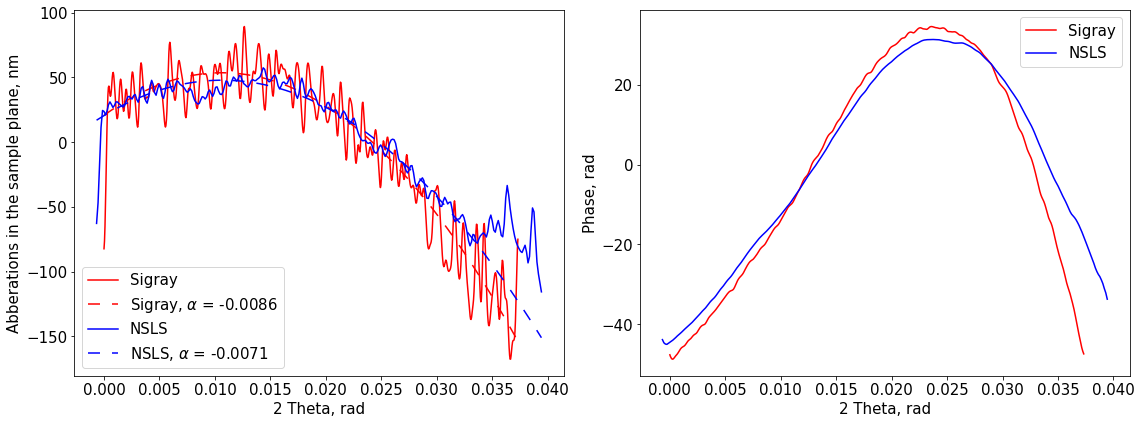

In [323]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fit_nsls = fit_obj_nsls.crop_data([10, 240]).fit()
fit = fit_obj.crop_data([10, 650]).fit(loss='linear')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.pixel_aberrations * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label='Sigray', c='r')
axes[0].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.model(fit['fit']) * fit_obj.pix_ap * fit_obj.defocus * 1e9,
             label=r'Sigray, $\alpha$ = ' + '{:.4f}'.format(fit['alpha']),
             c='r', linestyle='dashed', dashes=(8, 8))
axes[0].set_ylabel('aberrations in the sample plane, nm', fontsize=15)
axes[1].plot((fit_obj.pixels - fit_obj.pixels[0]) * fit_obj.pix_ap,
             fit_obj.phase, label='Sigray', c='r')
axes[1].set_ylabel('Phase, rad', fontsize=15)
axes[0].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.pixel_aberrations * fit_obj_nsls.pix_ap * fit_obj_nsls.defocus * 1e9,
             label='NSLS', c='b')
axes[0].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.model(fit_nsls['fit']) * fit_obj_nsls.pix_ap * fit_obj_nsls.defocus * 1e9,
             label=r'NSLS, $\alpha$ = ' + '{:.4f}'.format(fit_nsls['alpha']),
             c='b', linestyle='dashed', dashes=(8, 8))
axes[1].plot(fit_obj_nsls.pixels * fit_obj_nsls.pix_ap,
             fit_obj_nsls.phase, label='NSLS', c='b')
for ax in axes:
    ax.set_xlabel('2 Theta, rad', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
# plt.savefig('figures/nsls_sigray_comp.pdf')
plt.show()